Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 516.88 MB
GPU Memory Cached: 994.00 MB
Input shape: torch.Size([1, 103, 5, 5])
GFLOPs: 1.07
GFLOPs for the model: 1.07


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.278900,0.294786,0.892122
2,0.177400,0.110655,0.960262
3,0.112900,0.084298,0.978378
4,0.148300,0.067375,0.980014
5,0.075300,0.077368,0.981767
6,0.038400,0.109459,0.970430
7,0.047800,0.038720,0.988429
8,0.031900,0.048242,0.988429
9,0.037700,0.031640,0.993806
10,0.030800,0.021840,0.994039


GPU Memory Allocated: 516.41 MB
GPU Memory Cached: 1034.00 MB


Evaluation Results: {'eval_loss': 0.006386290770024061, 'eval_accuracy': 0.9989481065918654, 'eval_runtime': 3.7685, 'eval_samples_per_second': 2270.428, 'eval_steps_per_second': 35.558, 'epoch': 20.0}
Overall Accuracy (OA): 0.9989
Average Accuracy (AA): 0.9987
Kappa Coefficient (κ): 0.9986
F1 Score: 0.9989
Precision: 0.9989
Recall: 0.9989
Latency per image: 0.1315 ms
Latency per batch: 0.0042 seconds
Throughput: 7102.49 samples/second
Number of trainable parameters: 43.21 M


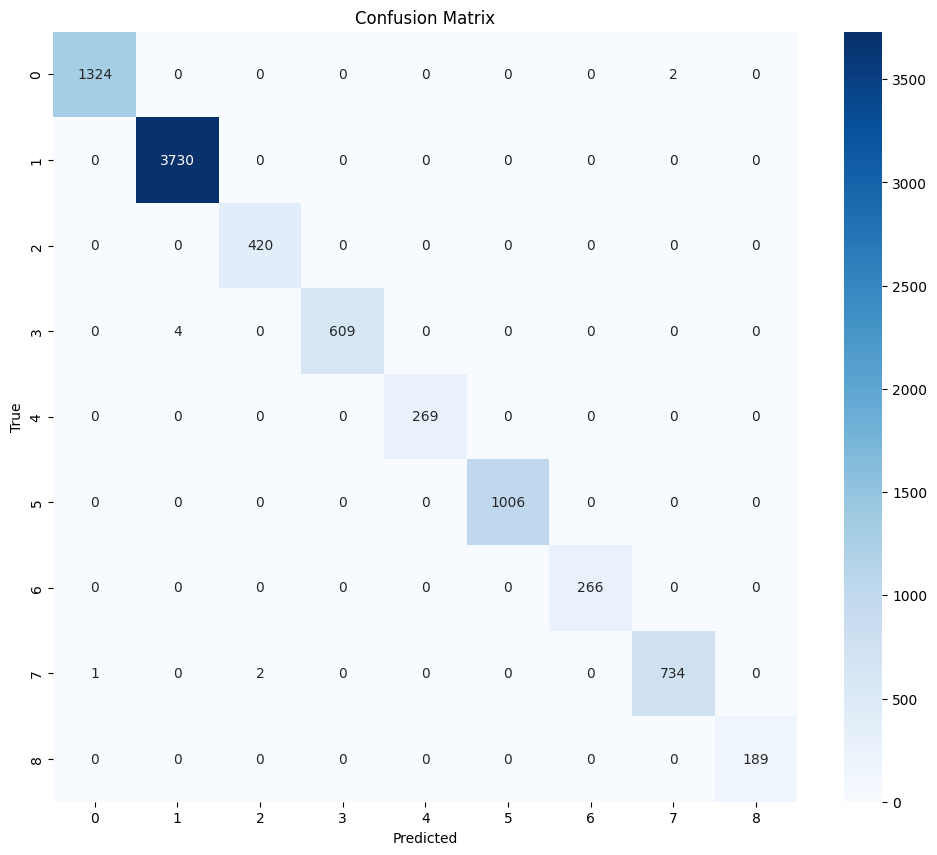

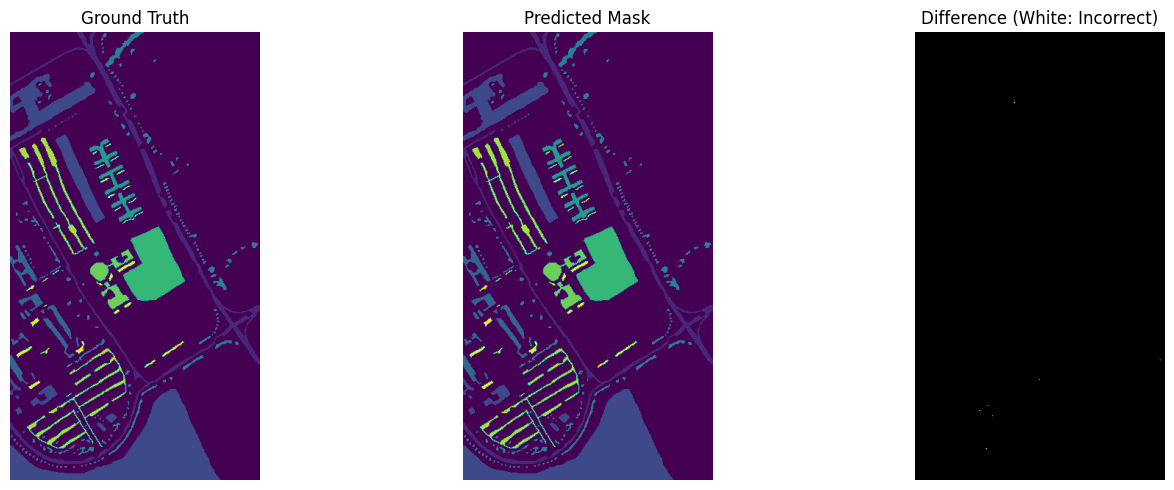

In [9]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.metrics import cohen_kappa_score
from einops import rearrange
import torch.cuda as cuda
from thop import profile
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_pavia_university(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt'] 
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class PaviaUniversityDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model Components
# ---------------------------------------------------

class SpectralAttention(nn.Module):
    """Spectral Attention Module"""
    def __init__(self, dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Linear(dim // 2, dim)
        )

    def forward(self, x):
        return self.mlp(x)

class EfficientAttention(nn.Module):
    """Efficient Attention with Linear Complexity"""
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k = k.softmax(dim=-2)
        context = torch.einsum('bhnd,bhne->bhde', k, v)
        out = torch.einsum('bhnd,bhde->bhne', q, context)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.proj(out)
        return out

class newViTBlock(nn.Module):
    """FastViT Block integrating efficient attention and an FFN"""
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = EfficientAttention(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class newFastViT(nn.Module):
    """Novel FastViT Model adapted for Hugging Face Trainer"""
    def __init__(self, image_size=5, patch_size=1, num_channels=103, num_classes=9,
                 embed_dim=768, depth=6, num_heads=12, mlp_ratio=4.):
        super().__init__()
        # Use 2D convolution for patch embedding
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2, embed_dim))
        self.blocks = nn.ModuleList([newViTBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)])
        self.spectral_attention = SpectralAttention(embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, labels=None):
        # x comes in as (B, C, H, W)
        x = self.patch_embed(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.spectral_attention(x.mean(dim=1))  # Global average pooling + spectral attention
        logits = self.head(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Main Execution
def calculate_latency_per_image(model, data_loader, device):
    """
    Calculate latency per image dynamically based on the dataset.
    """
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def calculate_latency_per_batch(model, data_loader, device):
    """
    Calculate latency per batch dynamically based on the dataset.
    """
    model.eval()
    total_time = 0
    num_batches = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            start_time = time.time()
            _ = model(inputs)
            total_time += time.time() - start_time
            num_batches += 1

    avg_latency = total_time / num_batches
    return avg_latency

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000 
    

# ---------------------------------------------------
# GPU Usage Logging
# ---------------------------------------------------

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

# ---------------------------------------------------
# GFLOPs Calculation
# ---------------------------------------------------

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops
# ---------------------------------------------------
# Visualize Predicted Mask
# ---------------------------------------------------

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = PaviaUniversityDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_pavia_university(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = PaviaUniversityDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = PaviaUniversityDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = newFastViT(
        image_size=5,
        patch_size=1,
        num_channels=103,  # Pavia University has 103 spectral bands
        num_classes=len(np.unique(y)),
        embed_dim=768,
        depth=6,
        num_heads=12,
        mlp_ratio=4.
    )

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=20,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Calculate latency per image
    latency_per_image = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency_per_image:.4f} ms")

    # Calculate latency per batch
    latency_per_batch = calculate_latency_per_batch(model, test_loader, device)
    print(f"Latency per batch: {latency_per_batch:.4f} seconds")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 69.74 MB
GPU Memory Cached: 1966.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 0.53
GFLOPs for the model: 0.53


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.380200,0.313026,0.867228
2,0.284100,0.226792,0.909303
3,0.202000,0.229229,0.912810
4,0.196200,0.175391,0.927887
5,0.177900,0.174040,0.929640
6,0.153600,0.144526,0.941561
7,0.146400,0.129743,0.948340
8,0.142900,0.135472,0.947055
9,0.150000,0.133742,0.945769
10,0.123300,0.131859,0.944834


GPU Memory Allocated: 108.56 MB
GPU Memory Cached: 2630.00 MB


Evaluation Results: {'eval_loss': 0.13185898959636688, 'eval_accuracy': 0.9448340345956054, 'eval_runtime': 7.4143, 'eval_samples_per_second': 1153.987, 'eval_steps_per_second': 18.073, 'epoch': 10.0}
Overall Accuracy (OA): 0.9448
Average Accuracy (AA): 0.9308
Kappa Coefficient (κ): 0.9262
F1 Score: 0.9434
Precision: 0.9470
Recall: 0.9448
Latency per image: 0.3419 ms
Throughput: 2958.60 samples/second
Number of trainable parameters: 3.26 M


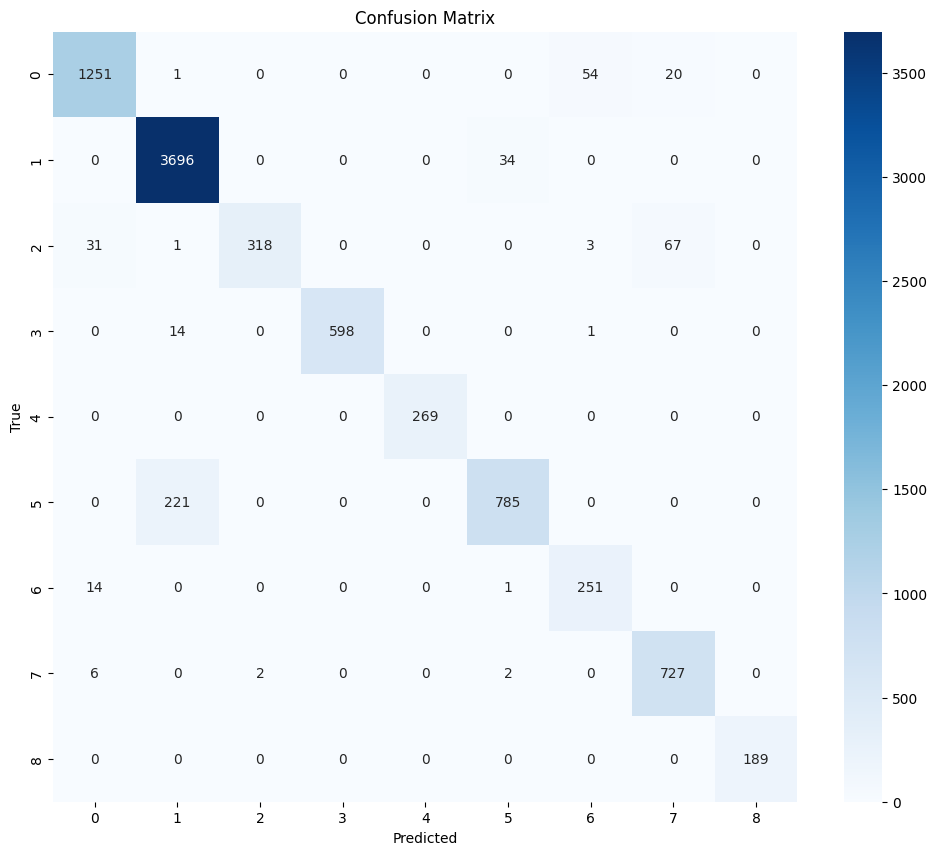

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1326
           1       0.94      0.99      0.96      3730
           2       0.99      0.76      0.86       420
           3       1.00      0.98      0.99       613
           4       1.00      1.00      1.00       269
           5       0.95      0.78      0.86      1006
           6       0.81      0.94      0.87       266
           7       0.89      0.99      0.94       737
           8       1.00      1.00      1.00       189

    accuracy                           0.94      8556
   macro avg       0.95      0.93      0.94      8556
weighted avg       0.95      0.94      0.94      8556



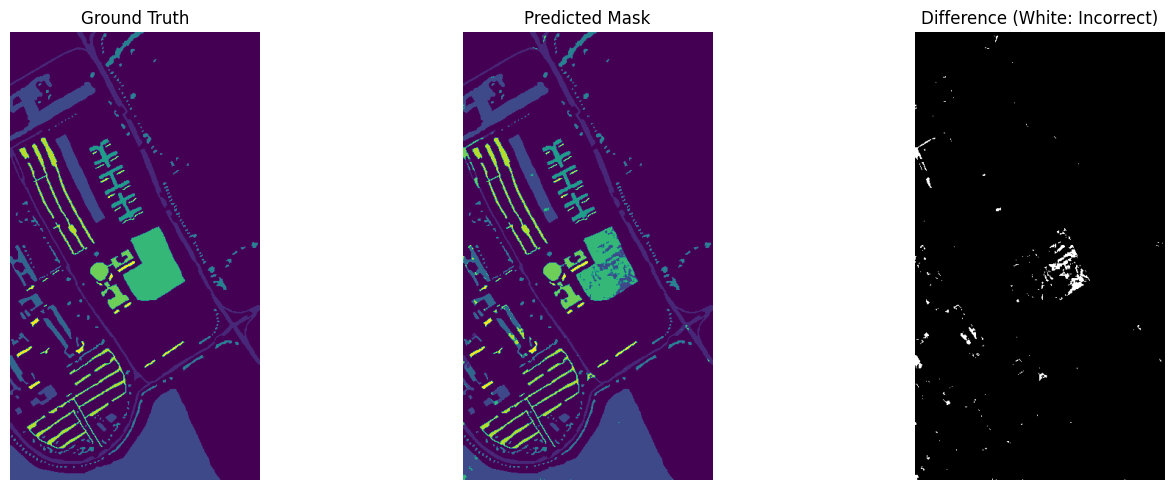

In [18]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('fastvit_t8', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 29.28 MB
GPU Memory Cached: 50.00 MB
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
GFLOPs: 0.38


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.430500,3.089660,0.765311
2,0.330700,0.610389,0.840346
3,0.218200,2.363118,0.817906
4,0.211200,1.758656,0.846190
5,0.202000,1.609973,0.849930
6,0.184200,0.767211,0.878682
7,0.174600,0.348329,0.884409
8,0.154500,0.339381,0.885577
9,0.149700,2.640542,0.848177
10,0.133400,0.431679,0.872604


GPU Memory Allocated: 63.54 MB
GPU Memory Cached: 3794.00 MB


Evaluation Results: {'eval_loss': 0.4316789209842682, 'eval_accuracy': 0.87260402057036, 'eval_runtime': 6.2356, 'eval_samples_per_second': 1372.12, 'eval_steps_per_second': 21.489, 'epoch': 10.0}
Overall Accuracy (OA): 0.8726
Average Accuracy (AA): 0.7940
Kappa Coefficient (κ): 0.8256
F1 Score: 0.8559
Precision: 0.8813
Recall: 0.8726
Latency per image: 0.2997 ms
Throughput: 3290.25 samples/second
Number of trainable parameters: 4.02 M


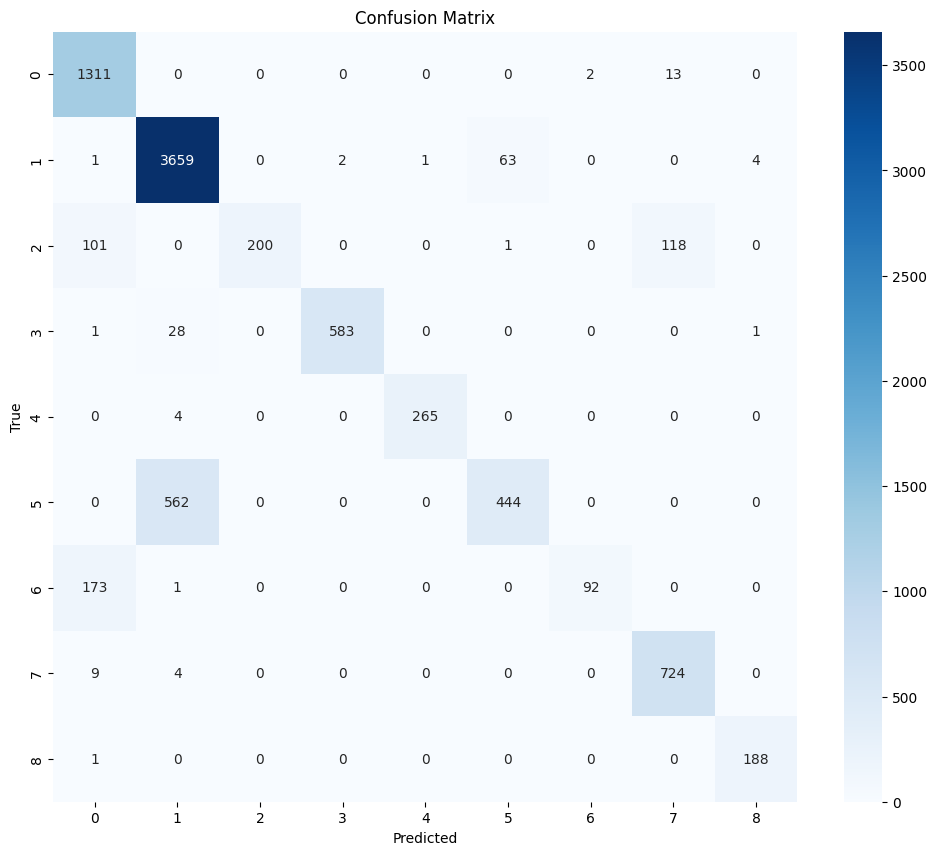

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1326
           1       0.86      0.98      0.92      3730
           2       1.00      0.48      0.65       420
           3       1.00      0.95      0.97       613
           4       1.00      0.99      0.99       269
           5       0.87      0.44      0.59      1006
           6       0.98      0.35      0.51       266
           7       0.85      0.98      0.91       737
           8       0.97      0.99      0.98       189

    accuracy                           0.87      8556
   macro avg       0.93      0.79      0.82      8556
weighted avg       0.88      0.87      0.86      8556



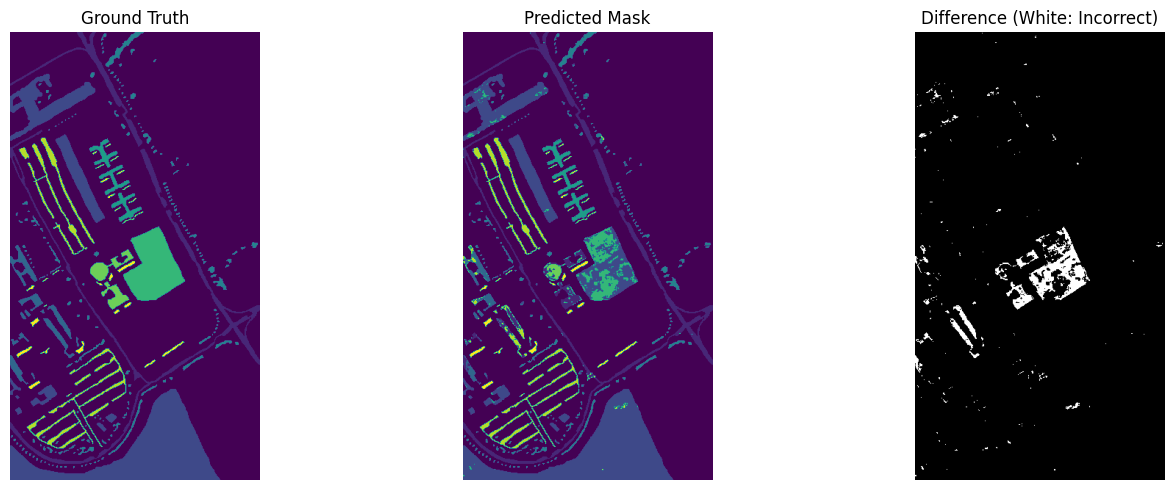

In [16]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, input_shape):
    dummy_input = torch.randn(*input_shape).to(next(model.parameters()).device)
    flops, _ = profile(model, inputs=(dummy_input,))
    gflops = flops / 1e9
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs
    input_shape = (1, 3, 224, 224)  # Example input shape (batch_size, channels, height, width)
    calculate_gflops(model, input_shape)

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 0.00 MB
GPU Memory Cached: 0.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 4.37
GFLOPs for the model: 4.37


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.268500,0.204922,0.919238
2,0.188200,0.175628,0.936185
3,0.132200,0.126512,0.953483
4,0.115600,0.109170,0.960145
5,0.101500,0.099529,0.968326
6,0.069900,0.082805,0.973001
7,0.051600,0.074819,0.974871
8,0.037000,0.049274,0.983520
9,0.031300,0.046827,0.984572
10,0.025900,0.034710,0.988897


GPU Memory Allocated: 336.20 MB
GPU Memory Cached: 4746.00 MB


Evaluation Results: {'eval_loss': 0.03470990061759949, 'eval_accuracy': 0.9888966806919121, 'eval_runtime': 20.6414, 'eval_samples_per_second': 414.507, 'eval_steps_per_second': 6.492, 'epoch': 10.0}
Overall Accuracy (OA): 0.9889
Average Accuracy (AA): 0.9886
Kappa Coefficient (κ): 0.9853
F1 Score: 0.9889
Precision: 0.9889
Recall: 0.9889
Latency per image: 0.3537 ms
Throughput: 2813.88 samples/second
Number of trainable parameters: 27.53 M


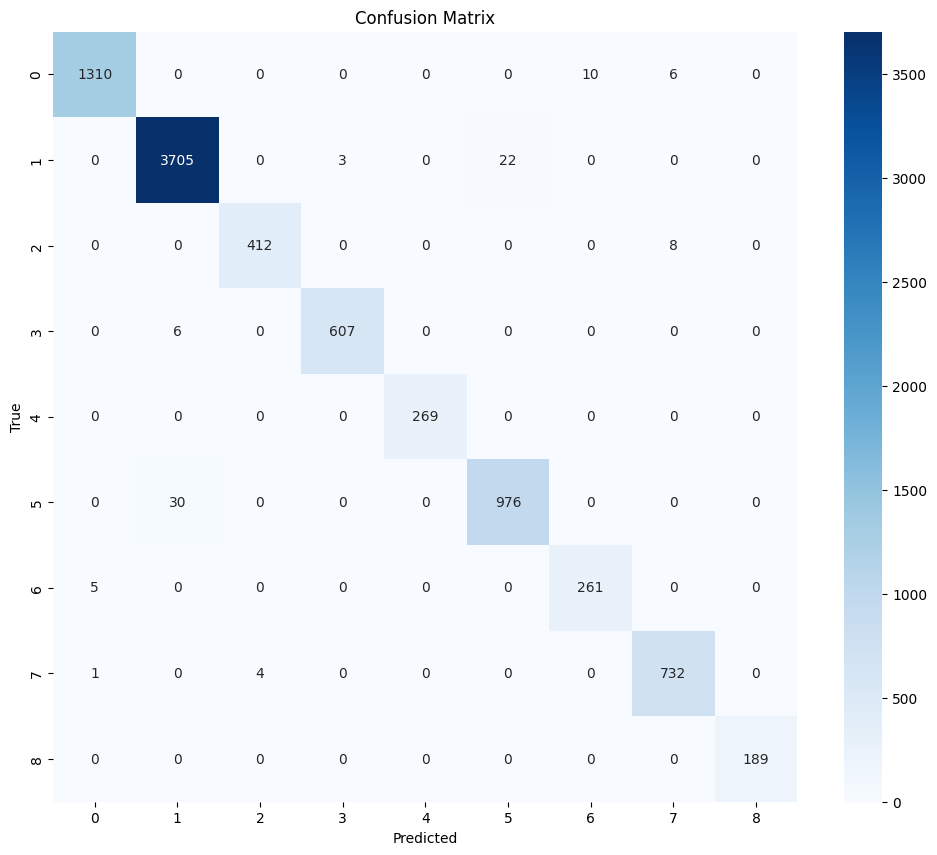

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1326
           1       0.99      0.99      0.99      3730
           2       0.99      0.98      0.99       420
           3       1.00      0.99      0.99       613
           4       1.00      1.00      1.00       269
           5       0.98      0.97      0.97      1006
           6       0.96      0.98      0.97       266
           7       0.98      0.99      0.99       737
           8       1.00      1.00      1.00       189

    accuracy                           0.99      8556
   macro avg       0.99      0.99      0.99      8556
weighted avg       0.99      0.99      0.99      8556



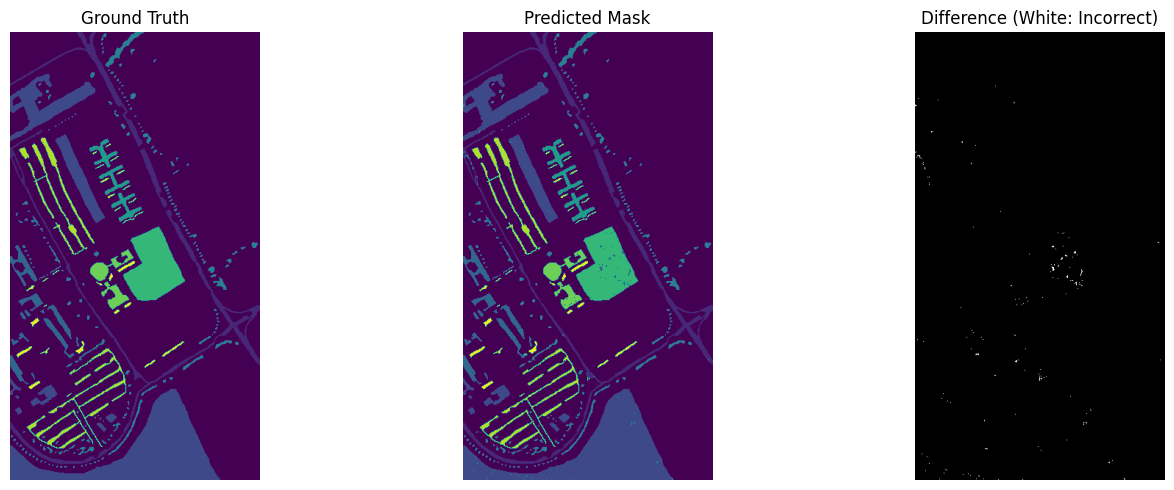

In [3]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 0.00 MB
GPU Memory Cached: 0.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 0.26
GFLOPs for the model: 0.26


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.570600,0.460303,0.839528
2,0.372300,0.223094,0.931276
3,0.253800,0.246663,0.918420
4,0.233400,0.229121,0.912576
5,0.203500,0.161537,0.941445
6,0.183200,0.147590,0.944367
7,0.182400,0.107314,0.958976
8,0.158700,0.121789,0.954418
9,0.175900,0.145787,0.947405
10,0.141800,0.155556,0.941561


GPU Memory Allocated: 27.59 MB
GPU Memory Cached: 1912.00 MB


Evaluation Results: {'eval_loss': 0.15555553138256073, 'eval_accuracy': 0.9415614773258532, 'eval_runtime': 4.7004, 'eval_samples_per_second': 1820.276, 'eval_steps_per_second': 28.508, 'epoch': 10.0}
Overall Accuracy (OA): 0.9416
Average Accuracy (AA): 0.9279
Kappa Coefficient (κ): 0.9217
F1 Score: 0.9404
Precision: 0.9467
Recall: 0.9416
Latency per image: 0.2653 ms
Throughput: 3795.46 samples/second
Number of trainable parameters: 0.95 M


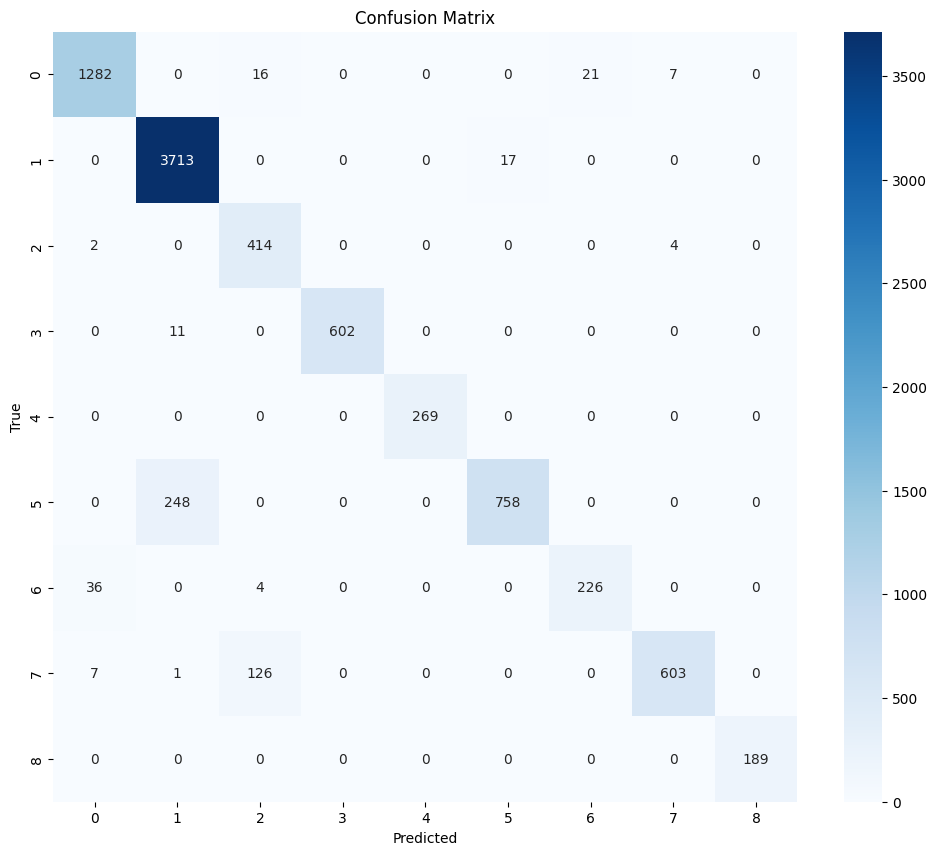

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1326
           1       0.93      1.00      0.96      3730
           2       0.74      0.99      0.84       420
           3       1.00      0.98      0.99       613
           4       1.00      1.00      1.00       269
           5       0.98      0.75      0.85      1006
           6       0.91      0.85      0.88       266
           7       0.98      0.82      0.89       737
           8       1.00      1.00      1.00       189

    accuracy                           0.94      8556
   macro avg       0.95      0.93      0.93      8556
weighted avg       0.95      0.94      0.94      8556



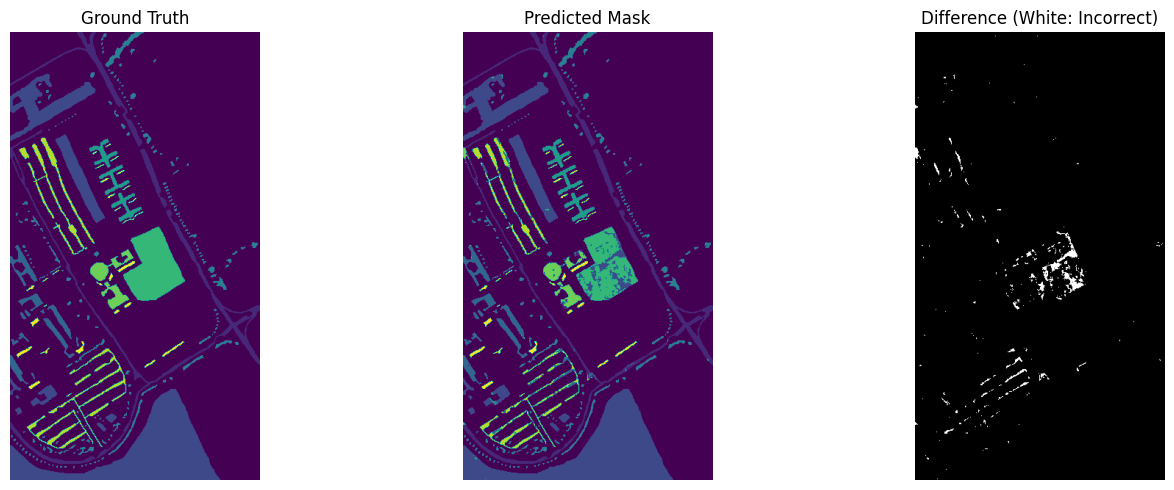

In [3]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('mobilevit_xxs', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 27.59 MB
GPU Memory Cached: 1912.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 0.20
GFLOPs for the model: 0.20


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.534300,0.432299,0.829243
2,0.366300,0.274467,0.893525
3,0.255700,0.253527,0.911290
4,0.235500,0.202765,0.925432
5,0.207300,0.188049,0.927536
6,0.195800,0.165378,0.938756
7,0.186500,0.153226,0.940743
8,0.178100,0.176553,0.930692
9,0.181000,0.168297,0.933146
10,0.169500,0.166040,0.934549


GPU Memory Allocated: 48.73 MB
GPU Memory Cached: 1192.00 MB


Evaluation Results: {'eval_loss': 0.16603994369506836, 'eval_accuracy': 0.9345488546049556, 'eval_runtime': 4.1487, 'eval_samples_per_second': 2062.352, 'eval_steps_per_second': 32.3, 'epoch': 10.0}
Overall Accuracy (OA): 0.9345
Average Accuracy (AA): 0.9112
Kappa Coefficient (κ): 0.9122
F1 Score: 0.9324
Precision: 0.9361
Recall: 0.9345
Latency per image: 0.4107 ms
Throughput: 2414.37 samples/second
Number of trainable parameters: 2.80 M


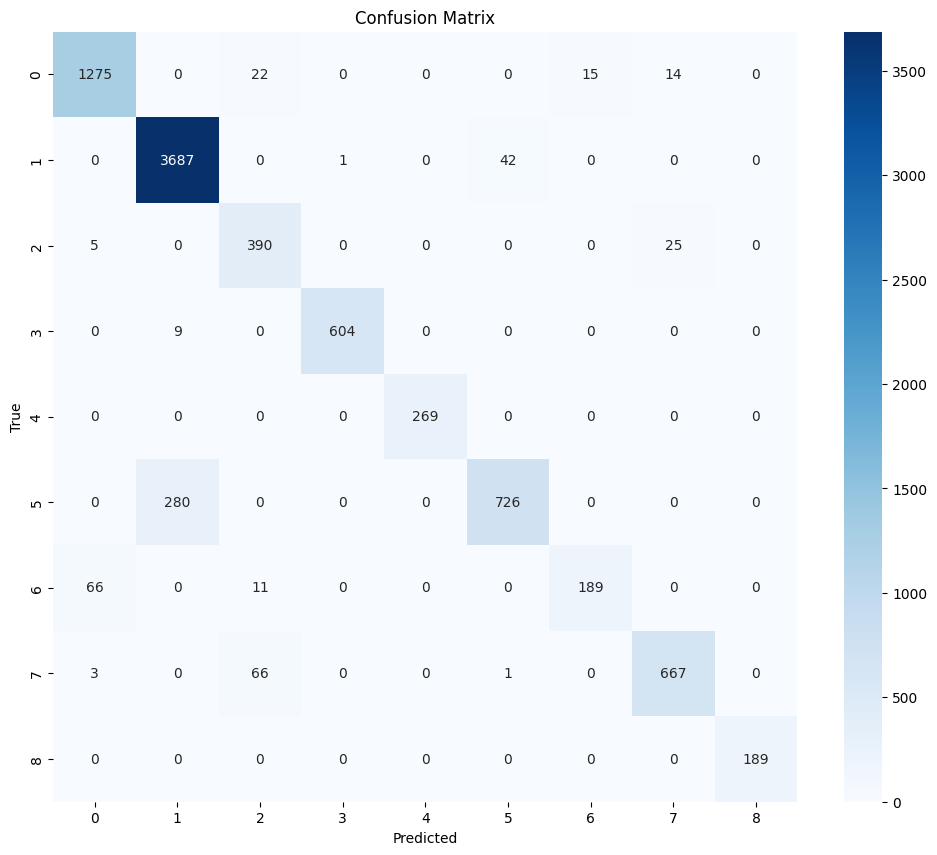

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1326
           1       0.93      0.99      0.96      3730
           2       0.80      0.93      0.86       420
           3       1.00      0.99      0.99       613
           4       1.00      1.00      1.00       269
           5       0.94      0.72      0.82      1006
           6       0.93      0.71      0.80       266
           7       0.94      0.91      0.92       737
           8       1.00      1.00      1.00       189

    accuracy                           0.93      8556
   macro avg       0.94      0.91      0.92      8556
weighted avg       0.94      0.93      0.93      8556



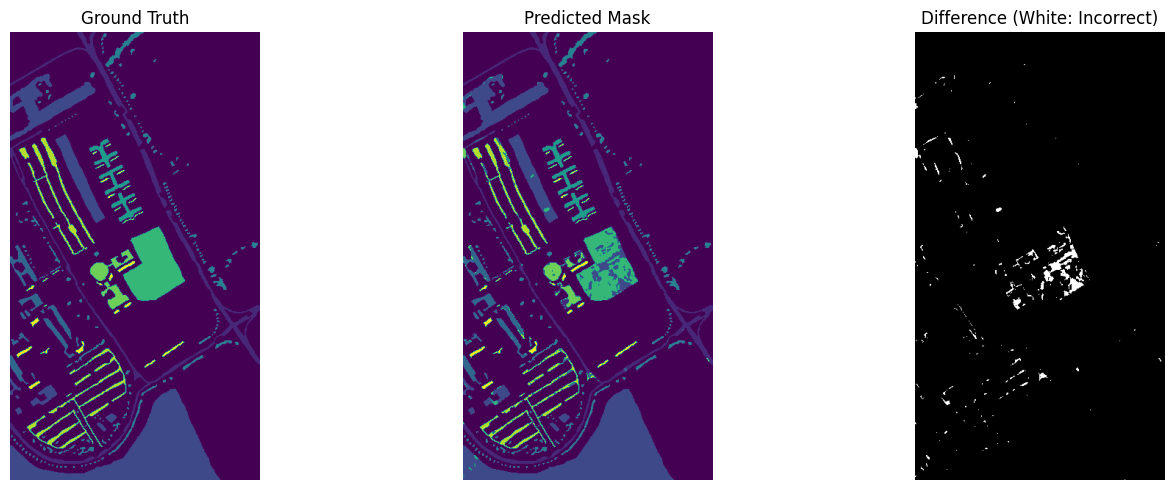

In [4]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('regnety_002', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 0.00 MB
GPU Memory Cached: 0.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 4.13
GFLOPs for the model: 4.13


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.332900,0.324070,0.868981
2,0.268700,0.237298,0.904862
3,0.209700,0.254079,0.900655
4,0.193900,0.185876,0.925900
5,0.171200,0.176007,0.929757
6,0.153700,0.147998,0.943782
7,0.127300,0.130912,0.944016
8,0.115600,0.137038,0.943315
9,0.117800,0.151814,0.937938
10,0.098300,0.120196,0.952548


GPU Memory Allocated: 291.85 MB
GPU Memory Cached: 3922.00 MB


Evaluation Results: {'eval_loss': 0.12019648402929306, 'eval_accuracy': 0.9525479195885928, 'eval_runtime': 12.3995, 'eval_samples_per_second': 690.026, 'eval_steps_per_second': 10.807, 'epoch': 10.0}
Overall Accuracy (OA): 0.9525
Average Accuracy (AA): 0.9433
Kappa Coefficient (κ): 0.9364
F1 Score: 0.9512
Precision: 0.9537
Recall: 0.9525
Latency per image: 0.2134 ms
Throughput: 4662.52 samples/second
Number of trainable parameters: 23.53 M


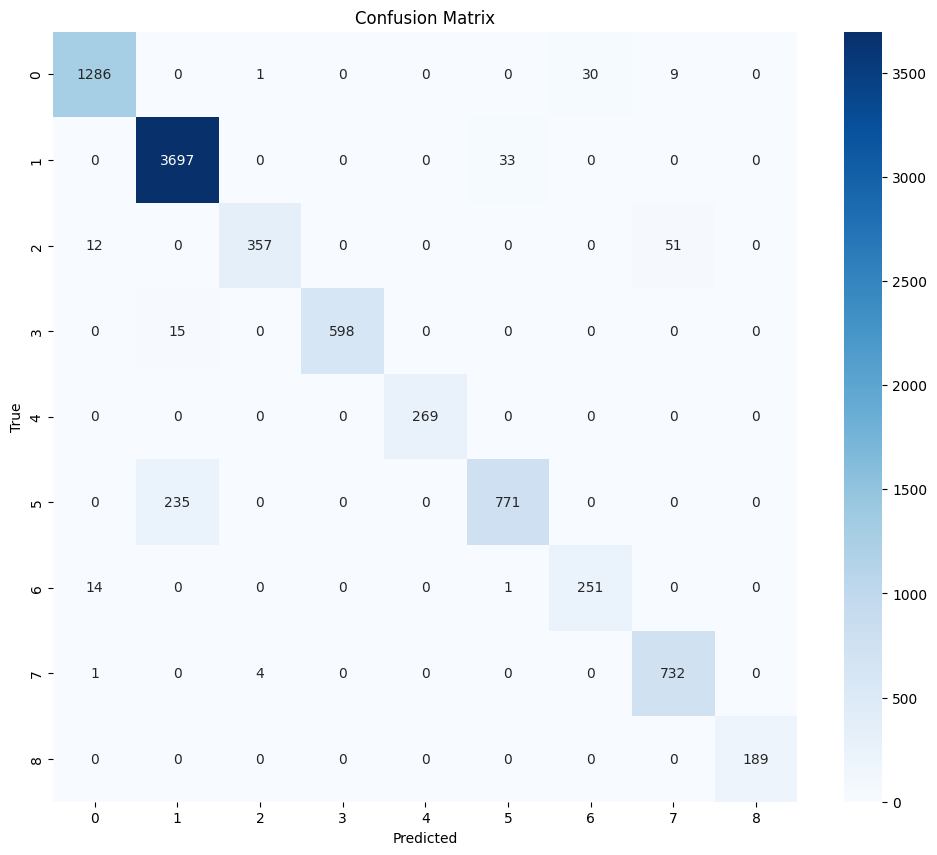

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1326
           1       0.94      0.99      0.96      3730
           2       0.99      0.85      0.91       420
           3       1.00      0.98      0.99       613
           4       1.00      1.00      1.00       269
           5       0.96      0.77      0.85      1006
           6       0.89      0.94      0.92       266
           7       0.92      0.99      0.96       737
           8       1.00      1.00      1.00       189

    accuracy                           0.95      8556
   macro avg       0.96      0.94      0.95      8556
weighted avg       0.95      0.95      0.95      8556



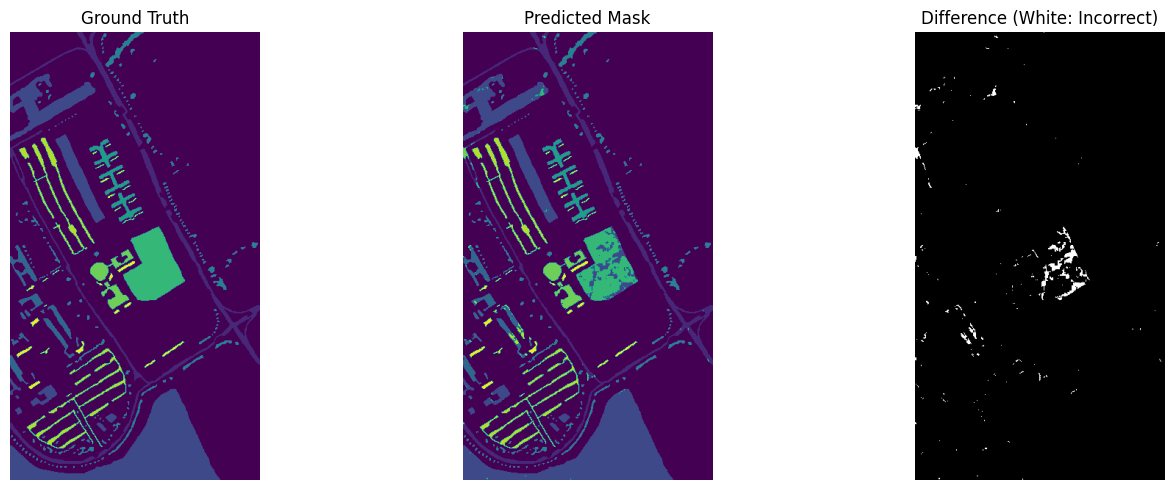

In [3]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('resnet50.a1_in1k', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Loading Pavia University dataset...
Image data shape: (610, 340, 103)
Ground truth shape: (610, 340)
GPU Memory Allocated: 0.00 MB
GPU Memory Cached: 0.00 MB
Input shape: torch.Size([1, 3, 5, 5])
GFLOPs: 16.86
GFLOPs for the model: 16.86


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.228700,0.318461,0.882655
2,0.169200,0.171630,0.933146
3,0.140200,0.145896,0.947756
4,0.110600,0.122504,0.960028
5,0.099200,0.083197,0.970196
6,0.079000,0.085460,0.970547
7,0.059500,0.075970,0.974053
8,0.049000,0.072667,0.977092
9,0.039700,0.062018,0.983053
10,0.024900,0.059899,0.983988


GPU Memory Allocated: 998.98 MB
GPU Memory Cached: 5338.00 MB


Evaluation Results: {'eval_loss': 0.05989901348948479, 'eval_accuracy': 0.9839878447872837, 'eval_runtime': 48.4903, 'eval_samples_per_second': 176.448, 'eval_steps_per_second': 2.763, 'epoch': 10.0}
Overall Accuracy (OA): 0.9840
Average Accuracy (AA): 0.9856
Kappa Coefficient (κ): 0.9788
F1 Score: 0.9840
Precision: 0.9840
Recall: 0.9840
Latency per image: 0.1722 ms
Throughput: 5686.85 samples/second
Number of trainable parameters: 85.81 M


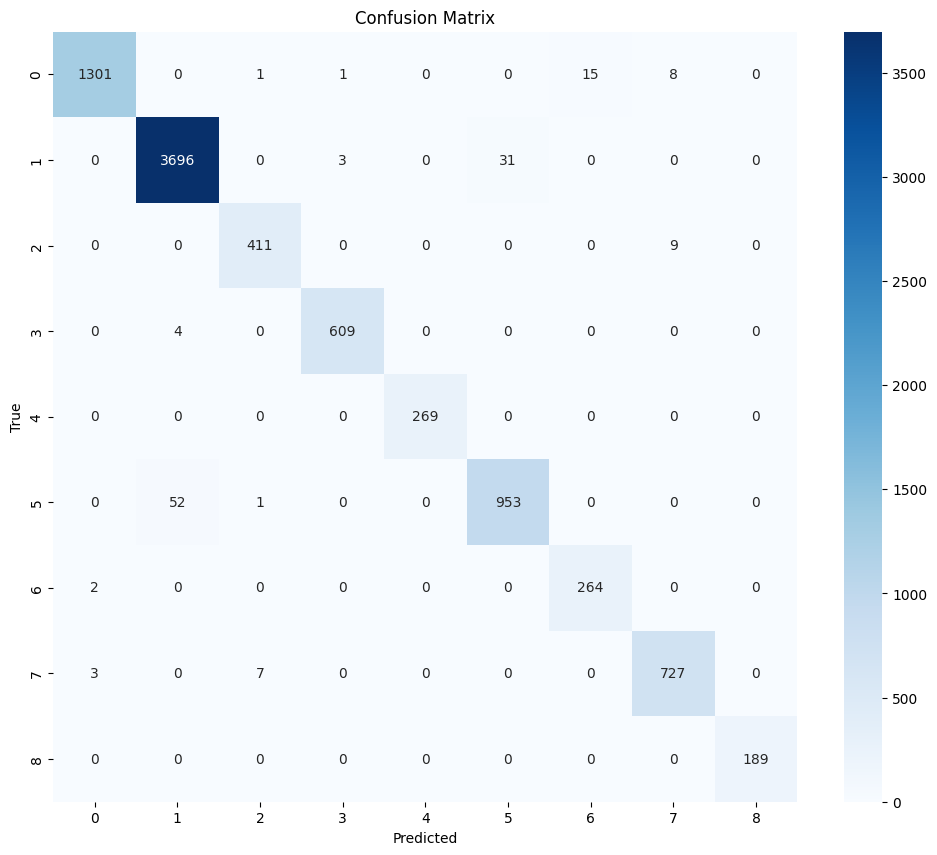

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1326
           1       0.99      0.99      0.99      3730
           2       0.98      0.98      0.98       420
           3       0.99      0.99      0.99       613
           4       1.00      1.00      1.00       269
           5       0.97      0.95      0.96      1006
           6       0.95      0.99      0.97       266
           7       0.98      0.99      0.98       737
           8       1.00      1.00      1.00       189

    accuracy                           0.98      8556
   macro avg       0.98      0.99      0.98      8556
weighted avg       0.98      0.98      0.98      8556



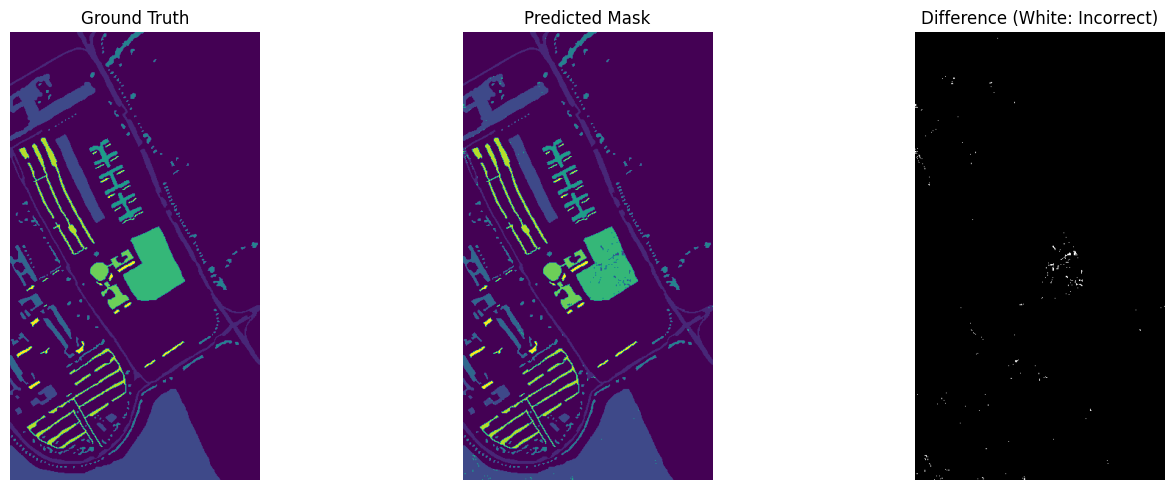

In [2]:
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.nn as nn
import time
from sklearn.decomposition import PCA
import timm  # Import timm for FastViT
from thop import profile  # For GFLOPs calculation
import torch.cuda as cuda

# ---------------------------------------------------
# Data Loading and Preprocessing
# ---------------------------------------------------

def load_indian_pines(image_file, gt_file):
    print("Loading Pavia University dataset...")
    image_data = scipy.io.loadmat(image_file)['paviaU']  # Adjust key if necessary
    ground_truth = scipy.io.loadmat(gt_file)['paviaU_gt']
    print(f"Image data shape: {image_data.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    return image_data, ground_truth

def preprocess_data(image_data, ground_truth, window_size=5):
    # Normalize the image data
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Add spatial information via padding
    padded_image = np.pad(image_data, ((window_size//2, window_size//2),
                                       (window_size//2, window_size//2),
                                       (0, 0)), mode='reflect')
    spatial_spectral_data = np.zeros((image_data.shape[0], image_data.shape[1],
                                      window_size, window_size, image_data.shape[2]))
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            spatial_spectral_data[i, j] = padded_image[i:i+window_size, j:j+window_size, :]

    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, image_data.shape[2])
    y = ground_truth.flatten()
    mask = y != 0
    spatial_spectral_data = spatial_spectral_data[mask]
    y = y[mask]

    # Reduce spectral dimensions to 3 using PCA
    pca = PCA(n_components=3)
    spatial_spectral_data = pca.fit_transform(spatial_spectral_data.reshape(-1, image_data.shape[2]))
    spatial_spectral_data = spatial_spectral_data.reshape(-1, window_size, window_size, 3)

    # Encode labels from 0 to num_classes-1
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return spatial_spectral_data, y, label_encoder

# ---------------------------------------------------
# Custom Dataset
# ---------------------------------------------------

class IndianPinesDataset(Dataset):
    def __init__(self, spatial_spectral_data, labels):
        self.spatial_spectral_data = spatial_spectral_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert image to (C, H, W)
        feature = self.spatial_spectral_data[idx].transpose(2, 0, 1)  # Shape: (3, window_size, window_size)
        label = self.labels[idx]
        return {
            'x': torch.tensor(feature, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------
# FastViT Model (from timm)
# ---------------------------------------------------

class FastViTForClassification(nn.Module):
    """FastViT Model for Classification"""
    def __init__(self, num_classes=16):
        super().__init__()
        # Load FastViT model from timm
        self.fastvit = timm.create_model('deit_tiny', pretrained=False, num_classes=num_classes)

    def forward(self, x, labels=None):
        # Resize input to 224x224 (FastViT's default input size)
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Forward pass through FastViT
        logits = self.fastvit(x)

        # If labels are provided, compute loss for Trainer
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

# ---------------------------------------------------
# Metrics and Latency Calculation
# ---------------------------------------------------

def calculate_latency_per_image(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['x'].to(device)
            batch_size = inputs.shape[0]
            total_images += batch_size

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)

    avg_latency_per_image = (total_time / total_images) * 1000  # Convert to milliseconds
    return avg_latency_per_image

def overall_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def average_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    return np.nanmean(class_accuracies)  # Handle NaN values for classes with no samples

def kappa_coefficient(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

def calculate_f1_precision_recall(y_true, y_pred):
    """
    Calculate F1 score, precision, and recall.
    """
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def count_model_parameters(model):
    """
    Count the total number of trainable parameters in the model and return in millions.
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params / 1_000_000  # Convert to millions

def calculate_throughput(model, data_loader, device):
    """
    Calculate the throughput of the model in samples per second.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        throughput: Throughput in samples per second.
    """
    model.eval()  # Set the model to evaluation mode
    total_samples = 0
    total_time = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch['x'].to(device)  # Move inputs to the specified device
            batch_size = inputs.size(0)  # Get the batch size
            start_time = time.time()  # Start timing
            _ = model(inputs)  # Forward pass
            total_time += time.time() - start_time  # Accumulate time
            total_samples += batch_size  # Accumulate samples

    throughput = total_samples / total_time  # Calculate throughput
    return throughput

def log_gpu_usage():
    if cuda.is_available():
        print(f"GPU Memory Allocated: {cuda.memory_allocated() / 1024 ** 2:.2f} MB")
        print(f"GPU Memory Cached: {cuda.memory_reserved() / 1024 ** 2:.2f} MB")
    else:
        print("GPU not available.")

def calculate_gflops(model, dataset, device):
    """
    Calculate GFLOPs dynamically based on the input shape of the dataset.
    
    Args:
        model: The model to evaluate.
        dataset: The dataset to determine the input shape.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        gflops: The number of GFLOPs for the given input shape.
    """
    # Get a sample input from the dataset
    sample = dataset[0]['x'].unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_shape = sample.shape  # Shape: (batch_size, num_channels, height, width)
    
    # Calculate FLOPs using the thop library
    flops, _ = profile(model, inputs=(sample,), verbose=False)
    gflops = flops / 1e9  # Convert to GFLOPs
    
    print(f"Input shape: {input_shape}")
    print(f"GFLOPs: {gflops:.2f}")
    return gflops

def generate_output_mask(model, image_data, ground_truth, label_encoder):
    spatial_spectral_data, _, _ = preprocess_data(image_data, ground_truth)
    dataset = IndianPinesDataset(spatial_spectral_data, np.zeros(len(spatial_spectral_data)))
    predictions = trainer.predict(dataset)
    y_pred_full = np.argmax(predictions.predictions, axis=1)
    output_mask = np.zeros_like(ground_truth)
    output_mask[ground_truth != 0] = y_pred_full + 1
    return output_mask

# ---------------------------------------------------
# Main Execution
# ---------------------------------------------------

if __name__ == "__main__":
    # File paths for the dataset
    image_file = "/kaggle/input/pavia-dataset2/PaviaU.mat"
    gt_file = "/kaggle/input/pavia-dataset2/PaviaU_gt.mat"

    # Load and preprocess data
    image_data, ground_truth = load_indian_pines(image_file, gt_file)
    spatial_spectral_data, y, label_encoder = preprocess_data(image_data, ground_truth)

    # Compute class weights (optional)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Split indices into train and test sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, stratify=y, random_state=42)

    # Create datasets
    train_dataset = IndianPinesDataset(spatial_spectral_data[train_indices], y[train_indices])
    test_dataset = IndianPinesDataset(spatial_spectral_data[test_indices], y[test_indices])

    # Initialize the FastViT model
    model = FastViTForClassification(num_classes=len(np.unique(y)))

    # Log GPU usage before training
    log_gpu_usage()

    # Calculate GFLOPs dynamically based on the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    gflops = calculate_gflops(model, train_dataset, device)
    print(f"GFLOPs for the model: {gflops:.2f}")

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable saving model weights
        load_best_model_at_end=False,  # No need to load the best model
        report_to="none"
    )

    # Create a data collator that returns a batch dictionary with expected keys
    data_collator = lambda data: {
        'x': torch.stack([d['x'] for d in data]),
        'labels': torch.stack([d['labels'] for d in data])
    }

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()},
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Log GPU usage after training
    log_gpu_usage()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Generate predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Calculate metrics
    oa = overall_accuracy(y[test_indices], y_pred)
    aa = average_accuracy(y[test_indices], y_pred)
    kappa = kappa_coefficient(y[test_indices], y_pred)
    f1, precision, recall = calculate_f1_precision_recall(y[test_indices], y_pred)
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient (κ): {kappa:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Calculate latency
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    latency = calculate_latency_per_image(model, test_loader, device)
    print(f"Latency per image: {latency:.4f} ms")

    # Calculate throughput
    throughput = calculate_throughput(model, test_loader, device)
    print(f"Throughput: {throughput:.2f} samples/second")

    # Count the number of parameters
    num_params = count_model_parameters(model)
    print(f"Number of trainable parameters: {num_params:.2f} M")

    # Confusion Matrix & Classification Report
    cm = confusion_matrix(y[test_indices], y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y[test_indices], y_pred, zero_division=0))

    # Generate and visualize the output mask
    output_mask = generate_output_mask(model, image_data, ground_truth, label_encoder)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(output_mask)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(133)
    difference = (ground_truth != output_mask).astype(int)
    plt.imshow(difference, cmap='gray')
    plt.title('Difference (White: Incorrect)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [1]:
!pip install thop